# Using flax for quickly setting up neural networks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FlorianMarquardt/machine-learning-for-physicists/blob/master/2024/03_Flax.ipynb)

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 3

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to build a little network using flax and how to evaluate the gradient of the cost function using jax, and how to use optax for optimizing the network.

Please also see the prior notebooks that show the more basic elements of jax:
- NN_CostFunctionGradientFromJax
- MoreJaxTricks
- OptaxForOptimization

The present notebook follows as closely as possible the 'OptaxForOptimization' example, highlighting that only very few changes are needed to use flax instead of basic jax!

First version by Florian Marquardt 2024. MIT License.

In [2]:
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap
import jax

from flax import linen as nn # the neural-network library from flax

import optax # for optimization

from matplotlib import pyplot as plt # plotting
%config InlineBackend.figure_format='retina'

## Defining the network and the cost function

In [31]:
# define a simple neural network using flax
class Network(nn.Module):
  hidden_neurons: int # a parameter we can choose during initialization
  output_neurons: int

  @nn.compact
  def __call__(self,x):
    # note: number of input neurons will be defined
    # by the shape of x when calling the network for the first time!
    x = nn.Dense(features=self.hidden_neurons)(x) # neurons for  hidden layer
    x = nn.relu(x) # relu activation
    x = nn.Dense(features=self.output_neurons)(x) # neurons for output
    x = nn.sigmoid(x) # sigmoid activation
    return x


In [32]:
# actually produce the network, with randomly initialized
# parameters

network = Network(hidden_neurons=3, output_neurons=1) # get an instance of the "Network" class
x = jnp.zeros((2,)) # dummy input for initialization
random_key = jax.random.key(42) # get a random key
params = network.init(random_key, x) # randomly initialize parameters

In [33]:
  # call to network.apply, which applies the network
  # to x, given the parameters params:
  network.apply(params,x)

Array([0.5], dtype=float32)

In [34]:
# Have a look at the way the parameters are stored:
# inside a dictionary! 'kernel' means the weight matrix!
params

{'params': {'Dense_0': {'kernel': Array([[-1.4292021 , -1.3605983 ,  0.6152747 ],
          [ 1.5901539 ,  0.11546879, -0.5445101 ]], dtype=float32),
   'bias': Array([0., 0., 0.], dtype=float32)},
  'Dense_1': {'kernel': Array([[ 0.87287366],
          [ 1.1059493 ],
          [-1.0556188 ]], dtype=float32),
   'bias': Array([0.], dtype=float32)}}}

## Compiling and batch processing

Everything the same as before without flax, except we write network.apply(...) where previously we wrote network(...), when network itself was a function. Now network is an object, namely an instance of the class Network.

In [35]:
# define a cost function (here: quadratic deviation)
def cost(params,x,y_target):
  return jnp.sum( ( network.apply(params,x) - y_target )**2 )

In [36]:
# batches: vmap does the trick!
batched_cost=vmap(cost,in_axes=(None,0,0))

In [37]:
# want to average the cost over the batch:
def average_cost(params,x,y_target):
  return jnp.average(batched_cost(params,x,y_target))

In [38]:
# compiled version of gradient of cost function, which
# returns both the value and the gradient:
batched_value_and_grad_cost=jit(value_and_grad(average_cost))

## Training using optax

Everything as before without flax, except now we already have nicely initialized parameters

### Function for producing a random batch of training samples

In [39]:
# produce training batches where the input is
# random 2D coordinates and the output is the corresponding
# value of a function that we want to fit

def myFunc(x):
    r2=x[:,0]**2+x[:,1]**2
    batch_size=jnp.shape(x)[0]
    return jnp.reshape(jnp.exp(-10*r2), (batch_size,1)) # to get proper shape

def make_batch(batch_size,key):
    inputs=jax.random.uniform(key,minval=-0.5,maxval=+0.5,shape=(batch_size,2))
    targets=myFunc(inputs)
    return inputs,targets



### Define a slightly larger network

More hidden neurons for better performance.

In [40]:
network = Network(hidden_neurons=200, output_neurons=1) # get an instance of the "Network" class
x = jnp.zeros((2,)) # dummy input for initialization
random_key = jax.random.key(47) # get a random key
params = network.init(random_key, x) # randomly initialize parameters

### Preparation of the optax 'optimizer'

In [41]:
# choose and prepare the optimizer
learning_rate=0.001
optimizer=optax.adam(learning_rate) # choose type of optimizer
opt_state=optimizer.init(params) # initialize the state of the optimizer

### Running the training loop

In [42]:
# now you can run a training loop:
num_batches=1000
batch_size=32
cost_history=[]

for train_step in range(num_batches):
  # producing the random batch
  # first, a new random key:
  random_key,new_key=jax.random.split(random_key)
  # produce a new batch (inputs x, desired outputs y):
  x,y = make_batch(batch_size,new_key)

  # get gradients and the current value of the cost function
  cost,grads = batched_value_and_grad_cost(params,x,y)

  # the optax part: calculate the updates and apply them to change 'params':
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  cost_history.append(cost)

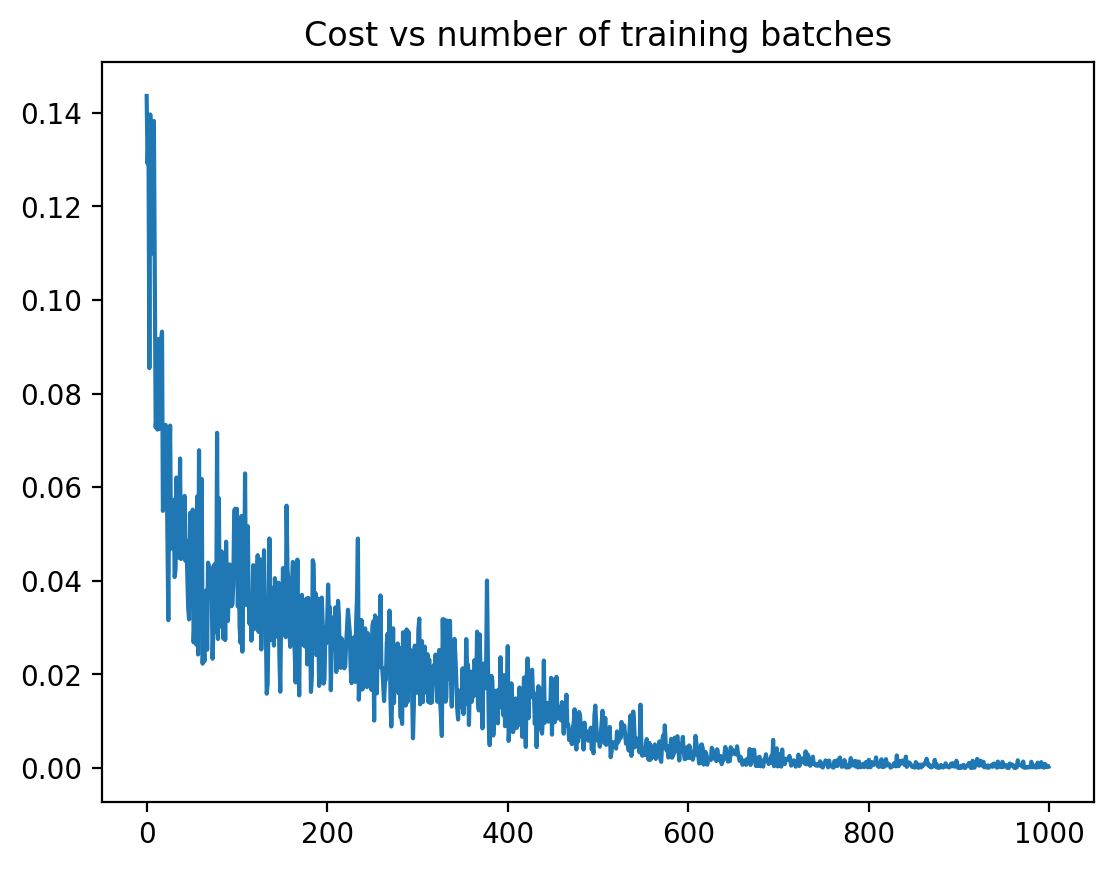

In [43]:
plt.plot(cost_history)
plt.title("Cost vs number of training batches")
plt.show()

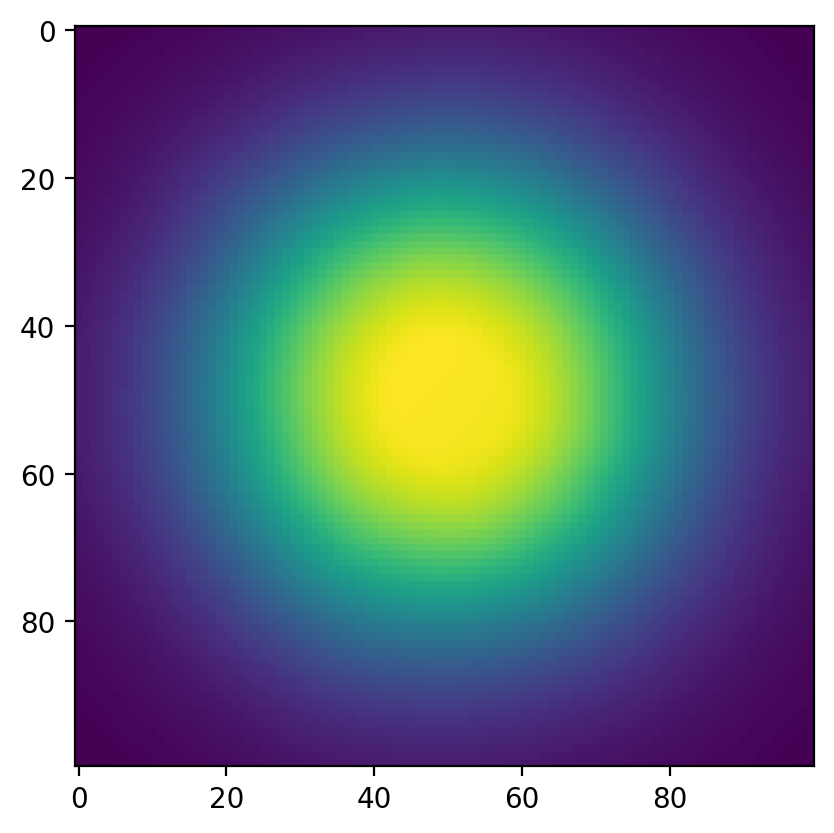

In [45]:
n_pixels=100
values=jnp.linspace(-0.5,0.5,n_pixels)
x0,x1=jnp.meshgrid(values,values)
x=jnp.stack([x0,x1],axis=-1)

result=network.apply(params,x) # shape (n_pixels,n_pixels,1)

plt.imshow(result[:,:,0])
plt.show()